In [26]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error

In [5]:
dtypes = {0: np.float32, 1: np.float64, 2: np.float64, 3: np.float64, 4:np.float64, 'y':np.float64}
train = pd.read_csv("_data/task_2/X_train.csv", usecols=range(1,7), names=[0, 1, 2, 3, 4, 'y'], skiprows=1, dtype=dtypes)
test = pd.read_csv("_data/task_2/X_test.csv", usecols=range(1,6), names=[0, 1, 2, 3, 4], skiprows=1, dtype=dtypes)

In [6]:
test[0].unique()

array([157., 678., 142., 588.,  97., 884., 642., 103.,  32., 599.,  94.,
       105., 554.,  92.,  14., 532.,  43.,  74., 191., 580., 916., 625.,
       137., 609., 192., 543.,  25., 667., 862., 861., 160., 689., 152.,
        81., 378., 577., 600., 547., 677., 337., 873., 181., 195., 128.,
       162., 148., 872., 175., 159., 555., 170., 653., 171.,   3., 270.,
       589.,  70.,  65.,  95., 213., 457., 356., 905.,  84., 180., 558.,
       141., 271.,  54.,  96., 281., 197., 117., 184., 536., 292.,  73.,
       334., 169., 304., 140., 106., 186., 182.,  37., 193., 566., 293.,
       303., 389., 569., 345., 608., 238.,  49., 136., 224., 235., 688.,
       590.])

In [7]:
# FillNA
n = 11
eps = 0.001

y = train['y']
y_0 = y.min()
y_1 = y.max()
d_y = (y_1 - y_0) / 51

y_s = np.linspace(y_0, y_1 - d_y + eps, n)

for y_0 in y_s:
    print(y_0, y_0 + d_y)



-1.6130000000000002 -1.5592745098039218
-1.3442725490196081 -1.2905470588235297
-1.0755450980392158 -1.0218196078431374
-0.8068176470588236 -0.7530921568627452
-0.5380901960784314 -0.48436470588235303
-0.26936274509803915 -0.2156372549019607
-0.0006352941176470672 0.05309019607843137
0.268092156862745 0.32181764705882343
0.5368196078431373 0.5905450980392157
0.8055470588235296 0.859272549019608
1.0742745098039215 1.128


In [8]:
test[[1,2,3,4,4]].dropna().shape

(93, 5)

In [9]:
#Можно ещё убрать данные ниже минимумов и максимумов (для деревьев)
print(train.describe())
print(test.describe())

                0           1           2           3           4           y
count  791.000000  768.000000  789.000000  795.000000  793.000000  796.000000
mean   533.680176   16.789850   16.684005    0.004528    0.242480   -0.408964
std    280.219788    0.901257    0.620565    0.457692    0.540453    0.547204
min      0.000000   14.789000   15.164000   -1.333000   -1.293000   -1.613000
25%    308.500000   16.105500   16.257000   -0.296500   -0.149000   -0.782250
50%    533.000000   16.825500   16.595000    0.023000    0.229000   -0.422500
75%    780.500000   17.417000   17.090000    0.296500    0.678000   -0.069000
max    989.000000   19.059000   18.327000    1.403000    1.673000    1.127000
                0          1          2           3           4
count  100.000000  94.000000  99.000000  100.000000  100.000000
mean   332.489990  16.965766  16.534384   -0.072590    0.711810
std    255.541946   0.692184   0.505205    0.432391    0.560022
min      3.000000  15.247000  15.482000   

In [10]:
train.describe()

,0,1,2,3,4,y
count,791.000000,768.000000,789.000000,795.000000,793.000000,796.000000
mean,533.680176,16.789850,16.684005,0.004528,0.242480,-0.408964
std,280.219788,0.901257,0.620565,0.457692,0.540453,0.547204
min,0.000000,14.789000,15.164000,-1.333000,-1.293000,-1.613000
25%,308.500000,16.105500,16.257000,-0.296500,-0.149000,-0.782250
50%,533.000000,16.825500,16.595000,0.023000,0.229000,-0.422500
75%,780.500000,17.417000,17.090000,0.296500,0.678000,-0.069000
max,989.000000,19.059000,18.327000,1.403000,1.673000,1.127000


In [11]:
def plot_all(df, x0, x1, y = None):
    for i in range(x0, x1):
        if y:
            df[[i, y]].dropna().plot.scatter(i, y)
        for j in range(i + 1, x1):
            df[[i, j]].dropna().plot.scatter(i, j)

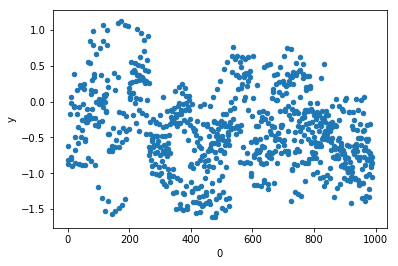

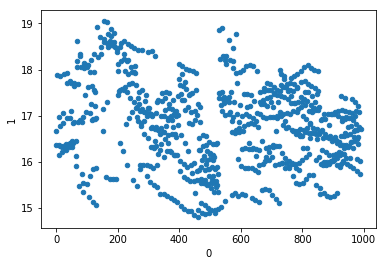

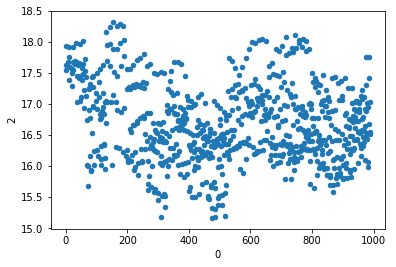

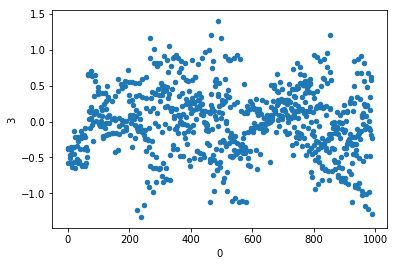

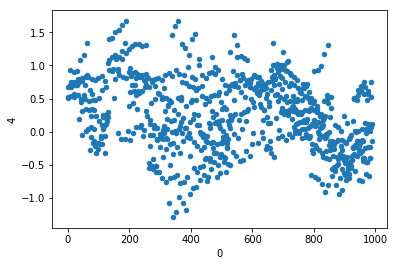

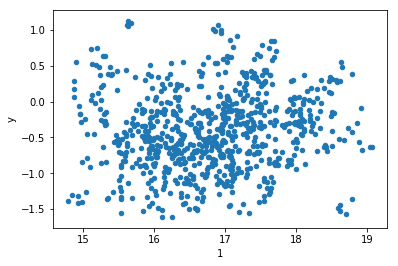

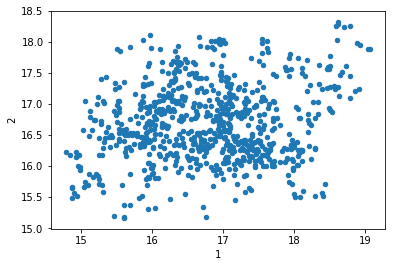

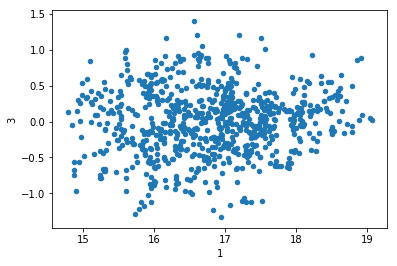

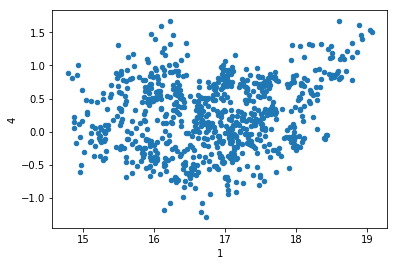

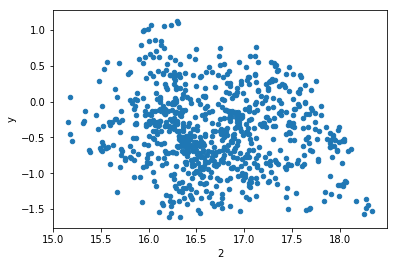

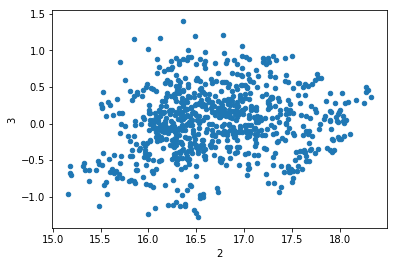

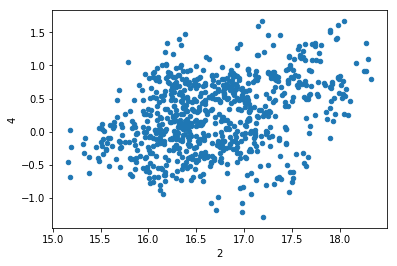

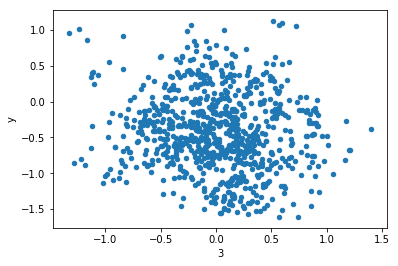

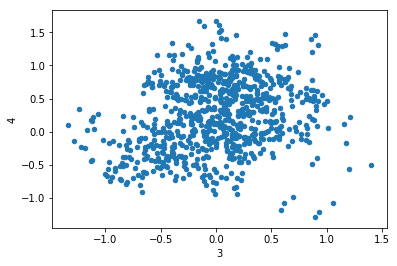

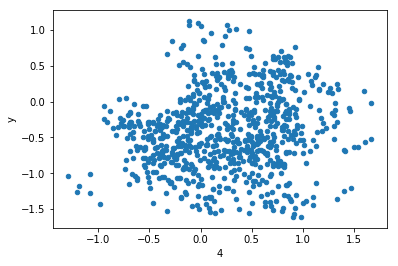

In [12]:
plot_all(train, 0, 5, 'y')

In [11]:
# На будущее: Колонку можно попробовать убрать
train[0].nunique()#.apply(lambda x: train[train[0] == x].shape[0]).unique()

791

In [13]:
train_x = train.dropna().drop('y', axis=1)
train_y = train.dropna()['y']
x_train, x_test, y_train, y_test = train_test_split(train_x, 
                                                    train_y, 
                                                    test_size = 100 / (train.dropna().shape[0] + 100), 
                                                    random_state = 42)

In [14]:
def scorer(estimator, X, y):
    return mean_absolute_error(y, estimator.predict(X))

In [15]:
pipeline = make_pipeline(StandardScaler(),
                         LinearRegression(n_jobs=-1))
cross_val_score(pipeline, x_train.drop(0, axis=1), y_train, cv = 9, scoring=scorer)

array([0.39859785, 0.38953399, 0.39669844, 0.39336205, 0.43153277,
       0.4986057 , 0.42555617, 0.42898083, 0.47771149])

In [20]:
pipeline = make_pipeline(StandardScaler(),
                         RandomForestRegressor(n_estimators=50, random_state=42))
res = cross_val_score(pipeline, x_train, y_train, cv = 9, scoring=scorer)
print(f'{np.mean(res)} +- {np.std(res)}')
print(scorer(pipeline.fit(x_train, y_train), x_test, y_test))

0.21985355506191123 +- 0.022554594752006055
0.20716988764044944


In [22]:
pipeline = make_pipeline(StandardScaler(),
                         XGBRegressor(n_estimators=1000, seed=42))
print(cross_val_score(pipeline, x_train, y_train, cv = 9, scoring=scorer))
print(scorer(pipeline.fit(x_train, y_train), x_test, y_test))

[0.31850964 0.26618429 0.26796478 0.28393225 0.26961105 0.24841546
 0.25662591 0.27760237 0.25256289]
0.23241762710957048


In [23]:
pipeline = make_pipeline(StandardScaler(),
                         LGBMRegressor(n_estimators=1000, random_state=42))
res = cross_val_score(pipeline, x_train, y_train, cv = 9, scoring=scorer)
print(f'{np.mean(res)} +- {np.std(res)}')
y_res = pipeline.fit(x_train, y_train).predict(x_test)
print(mean_absolute_error(y_test, y_res))

0.2232812863542882 +- 0.014541114852787954
0.20323071910174972


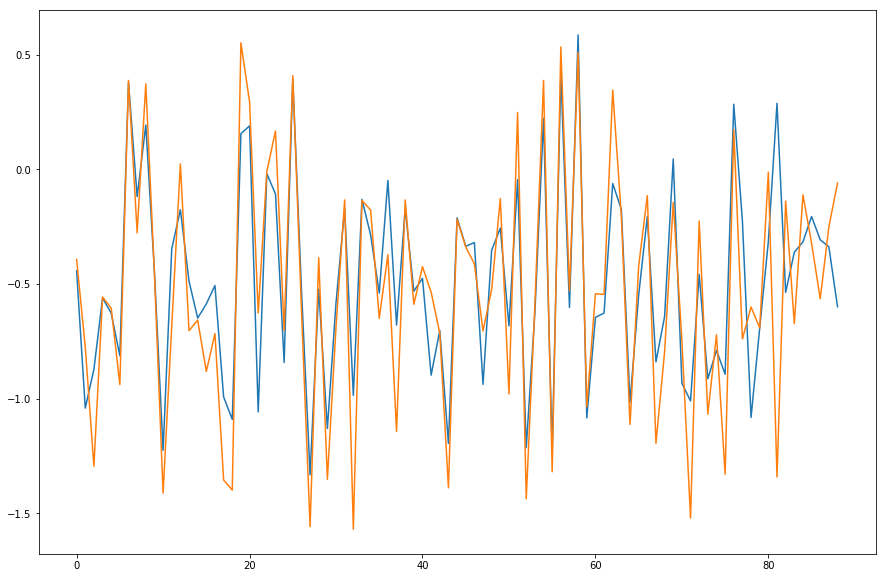

In [31]:
plt.figure(figsize=(15, 10))
plt.plot(np.arange(y_res.shape[0]), y_res, np.arange(y_res.shape[0]), y_test);

array([-0.44323035, -1.04157915, -0.87231571, -0.56162902, -0.62773642,
       -0.81314821,  0.37835973, -0.11955387,  0.19229635, -0.44685948,
       -1.22544958, -0.34802676, -0.17673469, -0.48820829, -0.64928518,
       -0.58718735, -0.50715853, -0.99258977, -1.09061152,  0.15497783,
        0.18893288, -1.05801885, -0.0200297 , -0.10816947, -0.84232096,
        0.39294906, -0.52193976, -1.33205318, -0.52371104, -1.13037631,
       -0.58192017, -0.17113584, -0.98592704, -0.13176985, -0.28607754,
       -0.54030514, -0.04892688, -0.67968618, -0.17210402, -0.53165775,
       -0.47592904, -0.89802578, -0.70259116, -1.19554611, -0.2122377 ,
       -0.33618388, -0.31985619, -0.93785089, -0.35337126, -0.25707535,
       -0.68309458, -0.04516313, -1.21408321, -0.62528312,  0.22163342,
       -1.22893705,  0.41724013, -0.60244005,  0.5854562 , -1.08432342,
       -0.64599729, -0.62704902, -0.06236507, -0.17552461, -1.01691079,
       -0.54953784, -0.20639173, -0.83987654, -0.64258392,  0.04

In [32]:
pipeline = make_pipeline(StandardScaler(),
                         LGBMRegressor(n_estimators=1000, random_state=42))
a = pipeline.fit(train.fillna(0).drop('y', axis=1), train.fillna(0)['y']).predict(test.fillna(0))
with open('profi.csv', 'w+') as f:
    for x in a:
        f.write(str(x) + '\n')

In [43]:
mean_absolute_error(np.ones_like(train_y) * np.median(train_y), train_y)

0.43763066666666667

In [51]:
with open('profi.csv', 'w+') as f:
    for x in a:
        f.write(str(x) + '\n')

In [123]:
# array([0.31867149, 0.26673338, 0.328525  , 0.38733405, 0.30722301,
#        0.31124562, 0.28732096, 0.32614342, 0.31070945])
#.drop(0, axis=1)
models = [
    LinearRegression(n_jobs=-1),
    
    
]

0.43399708333211146

In [119]:
l.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [103]:
train.dropna()

,0,1,2,3,4,y
0,440.0,15.753,17.167,0.087,-0.518,-0.316
1,429.0,16.240,17.125,0.230,-0.723,-0.501
2,451.0,15.313,17.021,-0.121,-0.398,-0.307
3,407.0,16.569,16.956,0.162,-0.853,-0.364
4,418.0,16.414,16.990,0.180,-0.831,-0.471
5,396.0,16.792,17.069,0.186,-0.947,-0.248
6,900.0,16.015,16.016,-0.846,-0.468,-0.858
7,397.0,17.431,16.961,-0.075,0.148,-0.893
8,922.0,15.882,15.940,-0.728,-0.544,-0.912
9,419.0,17.111,17.003,-0.415,0.097,-0.855
